**Note**: This notebook should take around **a minute** to run.

For a more comprehensive and detailed treatment of this problem, please refer to the [GitHub repository](https://github.com/HighDimensionalEconLab/transversality).

## The Economic Problem

Consider an asset that pays dividends $\{y_t\}_{t=0}^\infty$, and the sequence of dividends follows a law of motion described as:

$\begin{align}
y(t+1) = c + (1+g) y(t)
\end{align}$

This system can be written in a linear space setup as follows:

$\begin{align}
x(t+1) = Ax(t)\\
y(t) = Gx(t),
\end{align}$

where 

$x(t) \equiv \begin{bmatrix}
1\\
y(t)
\end{bmatrix}$

$
A \equiv \begin{bmatrix}
1 & 0\\
c & 1+g
\end{bmatrix}
$

$G = \begin{bmatrix}
1 & 0
\end{bmatrix}$

The price based on the fundamentals can be written as:

$
\begin{align}
p_f(t) = \sum_{j=0}^\infty \beta^j y(t+j) = G (\mathbf{I}-\beta A)^{-1} x(t)
\end{align}
$

The equation for the price can be written in a recursive way:

$\begin{align}
&p(t) = Gx(t) + \beta p(t+1)\\
&x(t+1) = A x(t)
\end{align}$

This system described above has infinitely many solutions; therefore, we need a condition (i.e., no-bubble condition) to rule out the solutions with bubbles:

$\begin{align}
\lim_{T\rightarrow \infty } \beta^T p(T) = 0
\end{align}$

#### Note on the No-Bubble Condition:

One of the main contributions of this paper is that one can ignore the no-bubble condition and completely rely on the implicit bias in deep learning to obtain the solution that is based on the fundamentals.

In this example, we focus on the case of:

1. $c = 0.01$, $g = -0.1$, $\beta = 0.9$, and $y_0 = 0.08$.


#### Importing Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
torch.manual_seed(123) # fixing the seed

#### Setting Up the Economic Parameters 


In [3]:
c = 0.01
g = -0.1
beta = 0.9
y_0 = 0.08

### Setting Up the Grid ($\mathcal{X}_{\text{train}}$) and the DataLoader


In [4]:
train_t_max = 29
time_grid = torch.arange(0.0, train_t_max , 1.0)
time_grid = time_grid.unsqueeze(dim =1)

#### Creating the Dividends Stream in the State-Space

In [5]:
A = torch.tensor([[1, 0], [c, 1 + g]]) 
G = torch.tensor([0.0, 1.0])  #
x_0 = torch.tensor([1.0, y_0])

In [6]:
y = []
x = []
x_t = x_0
for _ in range(train_t_max):
    x.append(x_t)
    y.append(G @ x_t)
    x_t = A @ x_t
    
y = torch.tensor(y).view(-1,1)#turning a list into a tensor

In [7]:
train_data = TensorDataset(time_grid,y)
data_loader = DataLoader(train_data, batch_size=len(time_grid), shuffle= False)

#### Setting up the Neural Network
This is an approximation for price $\hat{p}: \mathbb{R}_+ \rightarrow \mathbb{R}_+$.

$\hat{p}(\cdot)$ takes time as an input. The positivity of prices is going to be implemented by using a `Softplus` output layer.

In [8]:
class P_hat_NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128,):
        super().__init__()
        
        self.dim_hidden= dim_hidden
        
        self.p_hat = nn.Sequential(
            nn.Linear(1, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(dim_hidden, 1),
            nn.Softplus(beta=1.0) #To make sure the price stays positive
        )

    def forward(self, x):
        return self.p_hat(x)

#### Initializing the Neural Network and Defining the Optimizer

In [9]:
p_hat= P_hat_NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(p_hat.parameters(), lr=learning_rate) #Adam Optimizer 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9) #dampening the learning rate

In [10]:
num_epochs = 2001 # step of optimization
print_epoch_frequency = 200 # how often printing the results

### Implementing the Economics
Here, we implement the economic conditions in the form of residuals to be minimized, specifically:

The price residuals: the difference between the left-hand and right-hand sides of the recursive equation for price (i.e., eq. 5).




#### Defining the Residuals Function to be Used in the Optimization
This funtion defines the residuals for the recursive formulation of prices 

In [11]:
def residuals(batch):
    time, y_t = batch
    t_p1 = time+1 # t+1
    p_t = p_hat(time) # p(t), p_hat is the neural network
    p_tp1 = p_hat(t_p1) # p(t+1), p_hat is the neural network
    price_residulas =  y_t + beta * p_tp1 - p_t  # Gx(t)+ beta p(t+1) - p(t) = y(t)+ beta p(t+1) - p(t) 
    return price_residulas

### Training Loop (Optimization Process)
Here, we minimize the mean squared of price residuals over the grid points:

$\min_{\theta} \frac{1}{|\mathcal{X}_{\text{train}}|} \sum_{t\in \mathcal{X}_{\text{train}}} [y(t)+\beta \hat{p}(t+1;\theta)-\hat{p}(t;\theta)]^2$

where $\theta$ represents the coefficients of the neural network, and the optimization is done with gradient-based optimizers such as `Gradient Descent (GD)` and `Adam`.  



In [12]:
for epoch in range(num_epochs):
    for batch in data_loader:
        
        optimizer.zero_grad() # Resetting the gradients (with respect to NN coefficients)
        
        price_res = residuals(batch) # Constructing the price residuals
        
        loss = price_res.pow(2).mean() # Calculating the mean squared (over the grid points) of the price residulas residuals
        
        loss.backward() # Calculating the gradients (with respect to NN coefficients)
        optimizer.step() # Using the gradients to minimize the loss function
        
    scheduler.step() # Dampening the learning rate
    
    if epoch % print_epoch_frequency == 0:
        print(f"epoch = {epoch}, loss = {loss.detach().numpy():.2e}")

    


epoch = 0, loss = 4.28e-04
epoch = 200, loss = 1.33e-08
epoch = 400, loss = 1.22e-09
epoch = 600, loss = 6.82e-10
epoch = 800, loss = 5.86e-10
epoch = 1000, loss = 5.04e-10
epoch = 1200, loss = 4.33e-10
epoch = 1400, loss = 3.72e-10
epoch = 1600, loss = 3.21e-10
epoch = 1800, loss = 2.76e-10
epoch = 2000, loss = 2.39e-10


### Plotting the Results

#### Calculating the Approximate Capital and Consumption Path

In [13]:
# creating the test data
test_T = 50
time_grid_test = torch.arange(0.0, test_T , 1.0)
time_grid_test = time_grid_test.unsqueeze(dim =1)

In [14]:
p_hat_path = p_hat(time_grid_test).detach() # \hat{p}(t)

#### Closed Form Solution : Calculating the Price Path Based on the Fundamentals, $p_f(t)$
$p_f(t)$ is the price based on the fundamentalson the test data

In [15]:
H = G @ torch.inverse(torch.eye(2)- beta * A)

In [16]:
x_test = []
x_t_test = x_0
for _ in range(test_T):
    x_test.append(x_t_test)
    x_t_test = A @ x_t_test


x_test_path = torch.stack(x_test).t()
p_f_path = (H @ x_test_path).view(-1,1)

#### Calculating relative errors
Defined as 

$\begin{align}
\varepsilon_p(t) = \frac{\hat{p}(t)-p_f(t)}{p_f(t)}
\end{align}$

In [17]:
rel_error_path = (p_hat_path-p_f_path)/p_f_path

#### Plot Settings

In [18]:
fontsize= 14
ticksize = 14
figsize = (14, 4.5)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)

#### Plots

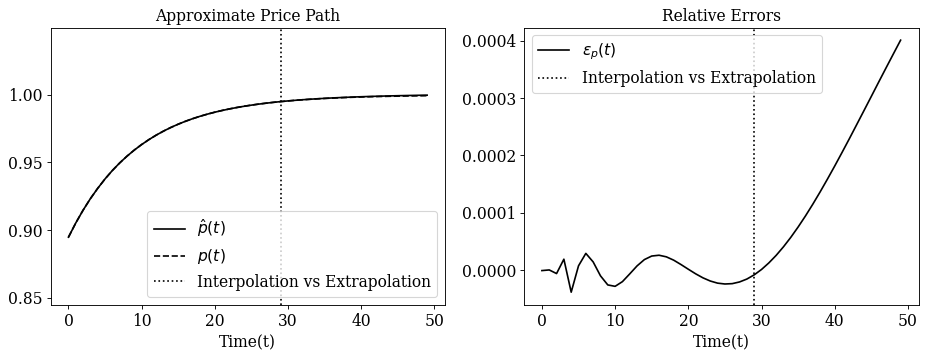

In [20]:
plt.subplot(1, 2 , 1)

plt.plot(time_grid_test,p_hat_path, color='k',  label = r"$\hat{p}(t)$")
plt.plot(time_grid_test,p_f_path, color='k', linestyle = "--" ,label = r"$p(t)$")
plt.xlabel(r"Time(t)")
plt.axvline(x= train_t_max , color='k', linestyle=':', label = "Interpolation vs Extrapolation")
plt.title(r"Approximate Price Path")
plt.ylim([p_hat_path[0]-0.05,p_hat_path[-1]*(1+0.05) ])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)

plt.plot(time_grid_test,rel_error_path, color='k',  label = r"$\varepsilon_p(t)$")
plt.xlabel(r"Time(t)")
plt.axvline(x= train_t_max , color='k', linestyle=':', label = "Interpolation vs Extrapolation")
plt.title(r"Relative Errors")
plt.legend(loc='best')